# Emotion Recognition 

This project implements a complete facial emotion recognition pipeline using the FER2013 dataset.

It follows a structured process of preprocessing, feature extraction, model training, evaluation, and real-time inference.

The goal is to recognize seven facial emotions from grayscale 48×48 images using machine learning models.

The pipeline integrates both texture (HOG) and geometry (landmark) features, and using classifiers:
- Fuzzy system

The process includes:
1. Data Loading and Preprocessing  
2. Data Augmentation  
3. Feature Extraction (HOG + Landmark)  
4. Feature Fusion and PCA  
5. Validation/Test Feature Preparation  
6. Feature Cleaning  
7. Fuzzy Model Training and Evaluation  
8. Model Saving and Confusion Matrix Visualization


# Environment Setup

Before running this notebook, please create the required Conda environment using the provided YAML file.  
This ensures all dependencies for the fuzzy emotion recognition pipeline are correctly installed.

## Step 1: Create the Conda environment
Open a terminal in the project root directory and run:
```bash
conda env create -f fuzzy_environment_mac.yml

conda activate fuzzy_emotion_recognition_310

In [126]:
# import necessary module 
import pandas as pd
import numpy as np
import os
import joblib
import cv2
import seaborn as sns
import random
import time
import matplotlib.pyplot as plt
import mediapipe as mp

from imgaug import augmenters as iaa
from joblib import Parallel, delayed
from itertools import product
from imblearn.over_sampling import SMOTE
from pathlib import Path
from tqdm import tqdm
from typing import Tuple, Dict
from skimage import exposure
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)


# 1. Data Loading and Splitting
The FER2013 dataset contains 48×48 grayscale facial images,
each labeled with one of seven emotion categories:
- 0 = angry
- 1 = disgust
- 2 = fear
- 3 = happy
- 4 = sad
- 5 = surprise
- 6 = neutral

The dataset provides three splits:
- Training (fit the model)
- PublicTest (validation for hyperparameter tuning)
- PrivateTest (final test for generalization)


In [127]:
# Load the FER2013 dataset
df = pd.read_csv("data/fer2013.csv")

# Split the dataset into three subsets based on the "Usage" column:
# - Training: used for model fitting
# - PublicTest: used for validation and hyperparameter tuning
# - PrivateTest: used for final testing and generalization
train_df = df[df["Usage"] == "Training"].copy()
val_df   = df[df["Usage"] == "PublicTest"].copy()
test_df  = df[df["Usage"] == "PrivateTest"].copy()

# Define emotion label mapping (integer to string)
emotion_labels = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

# Convert pixel strings to 48x48 grayscale arrays and normalize values to [0, 1]
def pixels_to_array(series):
    return np.vstack([np.fromstring(x, sep=' ') for x in series]).reshape(-1, 48, 48) / 255.0

# Convert each subset's pixel data into image arrays
X_train = pixels_to_array(train_df["pixels"])
X_val   = pixels_to_array(val_df["pixels"])
X_test  = pixels_to_array(test_df["pixels"])

# Extract corresponding emotion labels
y_train, y_val, y_test = (
    train_df["emotion"].values,
    val_df["emotion"].values,
    test_df["emotion"].values
)

# Display dataset sizes for verification
print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

Train=28709, Val=3589, Test=3589


# 2. Feature Extraction Functions
 
Define reusable feature extraction modules:
- **HOG**: Captures texture and edges.
- **Landmarks**: Uses Mediapipe FaceMesh for 468 keypoints, then stabilized for normalization.

In [128]:
# Extract HOG (Histogram of Oriented Gradients) features from input images
# Each image is processed independently in parallel for efficiency.
# Parameters:
#   images: list or array of grayscale images
#   pixels_per_cell: size of cell for gradient histogram
#   cells_per_block: number of cells per block for normalization
#   n_jobs: number of parallel CPU jobs (-1 uses all available cores)
#   desc: description string shown in tqdm progress bar
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                         n_jobs=-1, desc="Extracting HOG"):
    start_time = time.time()
    # Parallel computation of HOG feature vectors for all images
    features = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(hog)(
            img,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            feature_vector=True
        ) for img in tqdm(images, desc=desc)
    )
    # Convert list of features into a float32 NumPy array
    features = np.array(features, dtype=np.float32)
    print(f"Done: {features.shape} ({time.time()-start_time:.2f}s)")
    return features


# Normalize facial landmark coordinates to make them scale- and position-invariant
# Steps:
#   1. Subtract mean to center the coordinates
#   2. Scale by standard deviation norm
#   3. Normalize to [0, 1] range
def stabilize_landmarks(coords):
    if np.allclose(coords, 0):
        return coords
    mean = coords.mean(axis=0)
    coords_centered = coords - mean
    scale = np.linalg.norm(coords_centered.std(axis=0))
    if scale > 0:
        coords_centered /= scale
    coords_stable = coords_centered - coords_centered.min(axis=0)
    coords_stable /= coords_stable.max(axis=0)
    return coords_stable


# Extract facial landmark-based geometric features using MediaPipe FaceMesh
# Parameters:
#   images: list of grayscale images (48x48)
#   resize: target size before feeding into MediaPipe
#   verbose: whether to print detection statistics
# Returns:
#   features: NumPy array of flattened landmark coordinates (468*2 per face)
#   success_mask: boolean array indicating successful detections
def extract_landmark_features(images, resize=(96, 96), verbose=True):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
    features, success_mask = [], []
    for img in tqdm(images, desc="Landmark Extraction"):
        # Resize and convert grayscale to RGB (required by MediaPipe)
        img_resized = cv2.resize((img * 255).astype('uint8'), resize)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
        result = face_mesh.process(img_rgb)

        # If landmarks are detected, extract and normalize them
        if result.multi_face_landmarks:
            landmarks = result.multi_face_landmarks[0]
            coords = np.array([[lm.x, lm.y] for lm in landmarks.landmark])
            coords = stabilize_landmarks(coords)
            # Validate coordinates; discard abnormal detections
            if np.allclose(coords, 0) or np.max(coords) < 0.05:
                success_mask.append(False)
                coords = np.zeros(468 * 2)
            else:
                success_mask.append(True)
                coords = coords.flatten()
        else:
            # No face detected; use zero vector
            coords = np.zeros(468 * 2)
            success_mask.append(False)
        features.append(coords)

    # Release MediaPipe resources
    face_mesh.close()

    # Convert results to arrays
    features = np.array(features, dtype=np.float32)
    success_mask = np.array(success_mask, dtype=bool)

    # Print detection summary if enabled
    if verbose:
        print(f"Detected faces in {success_mask.sum()}/{len(images)} ({success_mask.mean()*100:.2f}%)")
    return features, success_mask

# 3. Data Augmentation
 
Earlier experiments using SMOTE for class balancing caused the feature distribution to become distorted after PCA, because synthetic samples generated by linear interpolation in feature space often collapsed into overlapping regions.
As a result, the classifier (and later the fuzzy system) tended to overfit to the dominant “happy” class, producing biased predictions.

To preserve the spatial and semantic integrity of facial expressions, data augmentation was adopted instead.
By applying transformations such as horizontal flips, small rotations (±7°), and brightness variations (±10%), the dataset achieves better balance while maintaining realistic facial structure.
This approach prevents artificial clustering and supports more stable fuzzy rule learning.    
- Horizontal flip    
- ±7° rotation     
- ±10% brightness adjustment    

In [129]:
# Make a copy of the original training data to preserve the original set
X_train_orig = X_train.copy()
y_train_orig = y_train.copy()
X_train_aug = X_train_orig.copy()
y_train_aug = y_train_orig.copy()

# Define a sequence of image augmentation operations:
# - Horizontal flip (mirror image)
# - Small random rotation within ±7 degrees
# - Brightness adjustment within ±10%
seq = iaa.Sequential([
    iaa.Fliplr(1.0),
    iaa.Affine(rotate=(-7, 7)),
    iaa.Multiply((0.9, 1.1))
])

# Determine the target number of samples for each class
# This is set to match the size of the largest class
target = max(pd.Series(y_train_orig).value_counts())

# Apply augmentation selectively to underrepresented emotion classes
for cls_id, cls_name in emotion_labels.items():
    # Get indices of all samples belonging to this emotion
    idx = np.where(y_train_orig == cls_id)[0]
    X_subset = X_train_orig[idx]
    n_need = target - len(idx)  # number of new samples required to balance the class
    if n_need > 0:
        # Randomly select samples (with replacement) from the existing subset
        sel = np.random.choice(len(X_subset), n_need, replace=True)
        # Apply the augmentation sequence defined above
        X_aug = seq(images=(X_subset[sel] * 255).astype(np.uint8))
        # Normalize pixel values to [0, 1]
        X_aug = np.array(X_aug, dtype=np.float32) / 255.0
        # Create corresponding label array
        y_aug = np.full(len(X_aug), cls_id)
        # Append augmented data and labels to the existing arrays
        X_train_aug = np.concatenate([X_train_aug, X_aug], axis=0)
        y_train_aug = np.concatenate([y_train_aug, y_aug], axis=0)

# Display the final number of training samples after augmentation
print(f"Final augmented training set size: {len(X_train_aug)}")

Final augmented training set size: 50505


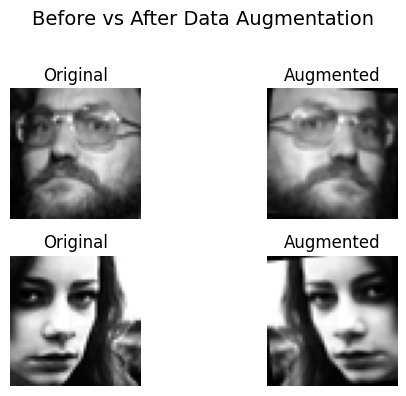

In [130]:
# Choose random subset of training images for visualization
n_samples = 2  # number of examples to visualize
idx = random.sample(range(len(X_train_orig)), n_samples)
X_subset = X_train_orig[idx]

# Apply augmentation sequence (same as training augmentation)
augmented_subset = seq(images=(X_subset * 255).astype(np.uint8))
augmented_subset = np.array(augmented_subset, dtype=np.float32) / 255.0

# Plot original vs augmented pairs side by side
fig, axes = plt.subplots(n_samples, 2, figsize=(6, n_samples * 2))
fig.suptitle("Before vs After Data Augmentation", fontsize=14)

for i in range(n_samples):
    # Original
    axes[i, 0].imshow(X_subset[i], cmap="gray")
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    # Augmented
    axes[i, 1].imshow(augmented_subset[i], cmap="gray")
    axes[i, 1].set_title("Augmented")
    axes[i, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Before: {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'sad': 4830, 'surprise': 3171, 'neutral': 4965}
After : {'angry': 7215, 'disgust': 7215, 'fear': 7215, 'happy': 7215, 'sad': 7215, 'surprise': 7215, 'neutral': 7215}


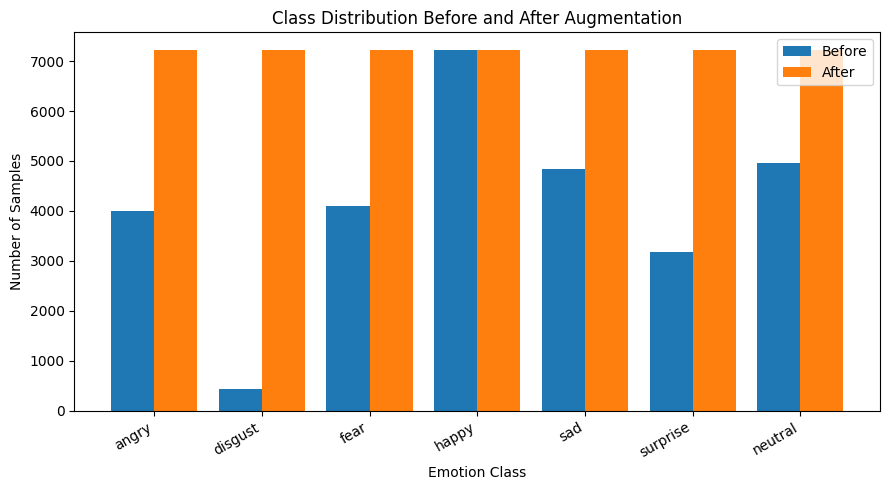

In [131]:
# Class distribution before vs after augmentation (aligned and robust)

classes = list(range(7))
labels  = [emotion_labels[i] for i in classes]

# Count with fixed length and order
before_counts = np.bincount(y_train_orig.astype(int), minlength=7)
after_counts  = np.bincount(y_train_aug.astype(int),  minlength=7)

# Optional: quick check
print("Before:", dict(zip(labels, before_counts)))
print("After :", dict(zip(labels,  after_counts)))

# Plot side-by-side bars with consistent indexing
import matplotlib.pyplot as plt
x = np.arange(len(classes))
width = 0.4

plt.figure(figsize=(9, 5))
plt.bar(x - width/2, before_counts, width, label="Before")
plt.bar(x + width/2, after_counts,  width, label="After")

plt.title("Class Distribution Before and After Augmentation")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.xticks(x, labels, rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


# 4. Feature Fusion and PCA
 
- Extract HOG + Landmark features  
- Merge them into a combined feature set  
- Apply StandardScaler and PCA (60 components)

This stage converts cleaned and augmented facial images into a compact, structured numerical representation suitable for machine learning and fuzzy classification.

The process begins by filtering out low-quality samples, then extracting both **texture** and **geometric** features from each image.  
These two feature types are combined and standardized to ensure consistent scaling across variables.  
Next, **Principal Component Analysis (PCA)** is applied to compress the high-dimensional feature space while preserving the majority of information relevant to emotion discrimination.

Finally, the trained standardization and PCA models are saved for later reuse during validation, testing, and real-time inference, ensuring that all data are processed through the same transformation pipeline.

The resulting dataset contains low-dimensional, well-structured features that represent each face in a way that balances texture detail, geometric structure, and computational efficiency.

In [132]:
# Remove invalid or blank samples based on pixel intensity
# - Discard images with very low mean brightness (mean <= 0.02)
# - Discard images that are completely zero
valid_idx = [i for i, x in enumerate(X_train_aug) if np.mean(x) > 0.02 and not np.allclose(x, 0)]
X_train_aug, y_train_aug = X_train_aug[valid_idx], y_train_aug[valid_idx]
print(f"Removed {len(valid_idx)} invalid/blank samples.")

# Extract HOG features from cleaned augmented images
X_train_aug_hog = extract_hog_features(X_train_aug, desc="Training (Aug) HOG after Cleaning")

# Extract facial landmark features using MediaPipe
X_train_aug_landmark, ok_train_aug = extract_landmark_features(X_train_aug)

# Keep only samples where landmark extraction succeeded
valid_idx_landmark = np.where(ok_train_aug == True)[0]
X_train_aug_hog = X_train_aug_hog[valid_idx_landmark]
X_train_aug_landmark = X_train_aug_landmark[valid_idx_landmark]
y_train_aug = y_train_aug[valid_idx_landmark]

# Combine HOG (texture) and landmark (geometry) features into a single feature matrix
X_train_combined = np.hstack([X_train_aug_hog, X_train_aug_landmark])

# Standardize features to zero mean and unit variance before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)

# Apply PCA to reduce dimensionality to 40 components for computational efficiency
PCA_DIM = 60
pca_final = PCA(n_components=PCA_DIM, svd_solver="randomized", random_state=42)
X_train_pca = pca_final.fit_transform(X_train_scaled)

# Save scaler and PCA models for consistent preprocessing in later stages (validation, test, demo)
os.makedirs("artifacts", exist_ok=True)
joblib.dump(scaler, "artifacts/scaler_combined.joblib")
joblib.dump(pca_final, f"artifacts/pca_fixed_{PCA_DIM}.joblib")

# Save processed training features and labels for future use
np.save("features/X_train_pca.npy", X_train_pca)
np.save("features/y_train_clean.npy", y_train_aug)

# Display summary of PCA transformation
print(f"PCA → {PCA_DIM} comps, shape {X_train_pca.shape}")

Removed 50488 invalid/blank samples.


Training (Aug) HOG after Cleaning:   0%|          | 16/50488 [00:00<16:15, 51.77it/s][Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.17519636266531172s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.003634929656982422s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007516145706176758s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.008281946182250977s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 216

Done: (50488, 900) (5.65s)


Landmark Extraction:   0%|          | 0/50488 [00:00<?, ?it/s]W0000 00:00:1761345765.063223 61615681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761345765.064934 61615681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/miniconda3/envs/fuzzy_emotion_reg/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Landmark Extraction: 100%|██████████| 50488/50488 [03:12<00:00, 262.26it/s]


Detected faces in 45188/50488 (89.50%)
PCA → 60 comps, shape (45188, 60)


This section applies the exact same preprocessing steps used during training to the validation and test datasets, ensuring consistency across all stages of model evaluation.

The process begins by loading the **StandardScaler** and **PCA** models that were fitted on the training data. These objects define how input features should be normalized and projected into a lower-dimensional space, preserving the statistical relationships learned during training.

Next, both the validation and test images undergo feature extraction:
- **HOG (Histogram of Oriented Gradients)** is computed to capture local texture and edge information.  
- **Facial landmarks** are detected using MediaPipe to encode geometric structure and key-point positions.

Only samples with successful landmark detection are retained to maintain alignment between feature sets.  
The extracted HOG and landmark features are then concatenated into unified matrices representing each face sample.

Finally, the data are standardized using the pre-trained scaler and projected through the same PCA transformation space as the training data.  
This guarantees that all datasets—training, validation, and test—exist in the same numerical feature space, allowing for fair and reliable model performance comparison.

The outputs of this step are the PCA-transformed validation and test feature matrices (`X_val_pca`, `X_test_pca`) and their corresponding emotion labels.

In [133]:
# Load the previously saved StandardScaler and PCA models
# These ensure the validation and test data are preprocessed identically to the training data
scaler = joblib.load("artifacts/scaler_combined.joblib")
PCA_DIM = 60
pca_final = joblib.load(f"artifacts/pca_fixed_{PCA_DIM}.joblib")

# Extract HOG features for both validation and test datasets
X_val_hog   = extract_hog_features(X_val, desc="Validation HOG")
X_test_hog  = extract_hog_features(X_test, desc="Test HOG")

# Extract facial landmarks for both validation and test datasets
X_val_landmark, ok_val   = extract_landmark_features(X_val)
X_test_landmark, ok_test = extract_landmark_features(X_test)

# Keep only samples where landmark extraction succeeded
val_valid_idx, test_valid_idx = np.where(ok_val == True)[0], np.where(ok_test == True)[0]

# Combine HOG and landmark features into unified feature matrices
X_val_combined  = np.hstack([X_val_hog[val_valid_idx], X_val_landmark[val_valid_idx]])
X_test_combined = np.hstack([X_test_hog[test_valid_idx], X_test_landmark[test_valid_idx]])

# Filter labels to match successfully processed samples
y_val_valid, y_test_valid = y_val[val_valid_idx], y_test[test_valid_idx]

# Apply the same scaler (normalization) used in training
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)

# Apply PCA transformation using the same projection space as training
X_val_pca = pca_final.transform(X_val_scaled)
X_test_pca = pca_final.transform(X_test_scaled)





Validation HOG:   0%|          | 0/3589 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.006988048553466797s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007546186447143555s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0087890625s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.012773990631103516s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.

Done: (3589, 900) (0.45s)


Test HOG:   0%|          | 0/3589 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0018699169158935547s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.006250858306884766s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.01128697395324707s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.012945890426635742s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (

Done: (3589, 900) (0.46s)


Landmark Extraction:   0%|          | 0/3589 [00:00<?, ?it/s]W0000 00:00:1761345970.101019 61617408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761345970.103887 61617406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/miniconda3/envs/fuzzy_emotion_reg/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Landmark Extraction: 100%|██████████| 3589/3589 [00:13<00:00, 261.97it/s]
I0000 00:00:1761345983.857595 61253507 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2


Detected faces in 3276/3589 (91.28%)


Landmark Extraction:   0%|          | 0/3589 [00:00<?, ?it/s]W0000 00:00:1761345983.859371 61617543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761345983.861791 61617542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Landmark Extraction: 100%|██████████| 3589/3589 [00:14<00:00, 255.18it/s]


Detected faces in 3283/3589 (91.47%)


### 1. Explained Variance of PCA Components

The first plot shows the cumulative explained variance ratio across principal components.
The curve rises sharply within the first 10–15 components, indicating that most of the data variance is captured early.
After approximately 60 components, the curve flattens and reaches about 75–80% of total variance, showing diminishing returns from adding more components.

Hence, setting PCA = 60 offers a good trade-off between dimensionality reduction and information retention.



### 2. 2D Projection Using the First Two PCA Components

This scatter plot visualizes all training samples in the space of the first two PCA components.
Each point represents one face sample, colored by its emotion label.

Observations:
- Emotion classes are highly overlapping, indicating that linear separation is limited in PCA space.    
- The “neutral” and “happy” samples occupy large central regions, reflecting their dominance in feature variation.    
- Other emotions (e.g., fear, sad, angry) appear scattered along the periphery without strong clustering.    

This confirms that PCA alone cannot fully separate emotional categories, motivating the later use of fuzzy modeling to handle gradual and uncertain boundaries.



### 3. Nonlinear Visualization with t-SNE

The t-SNE plot provides a nonlinear embedding of the same features, emphasizing local neighborhood structures.
Compared to PCA, clusters appear slightly more distinct, but still exhibit partial overlaps between adjacent emotions.

Key takeaways:
- t-SNE better captures nonlinear relationships and subtle differences between emotion manifolds.    
- Classes like happy and surprise form denser areas, while fear and sad remain more dispersed.    
Overall, emotion distributions are continuous rather than discrete, supporting the suitability of fuzzy systems for handling uncertainty in emotion transitions.

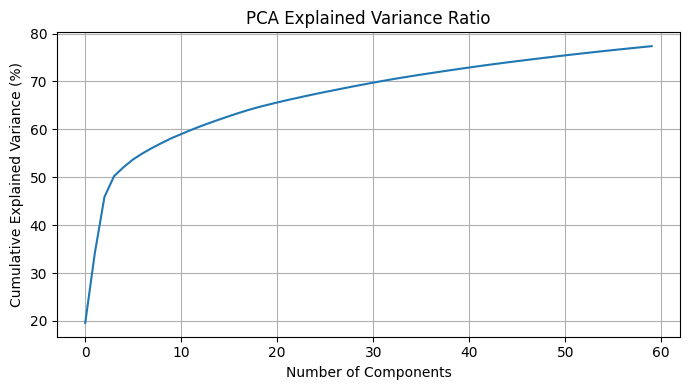

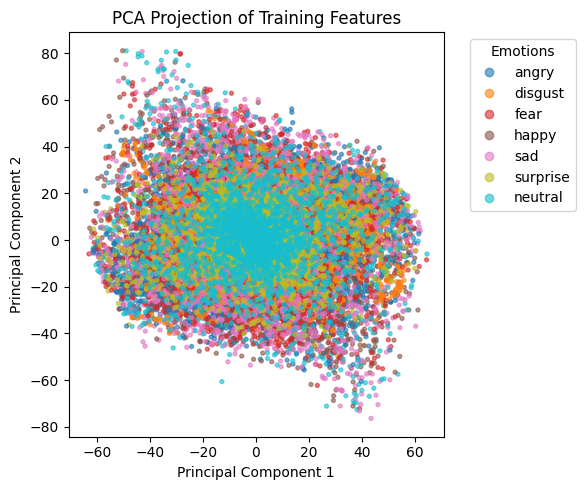

/opt/miniconda3/envs/fuzzy_emotion_reg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


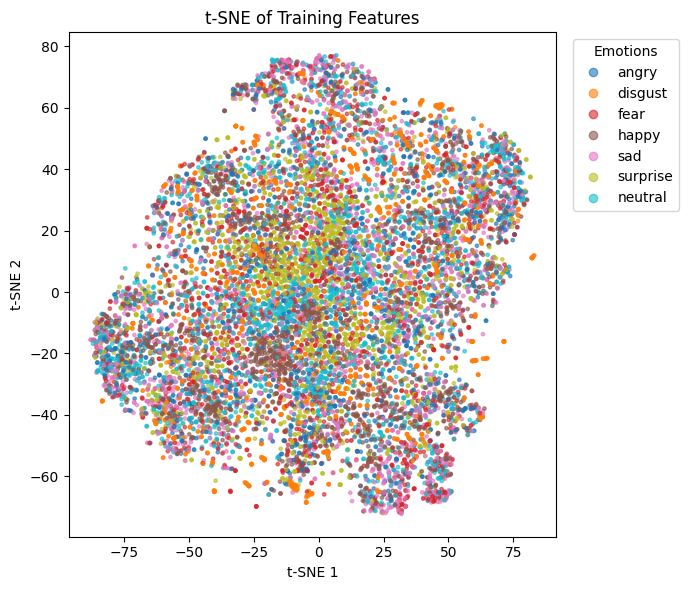

In [134]:
y_train_pca = y_train_aug  # rename for clarity
# Explained Variance Ratio (how much information each principal component keeps)
plt.figure(figsize=(7, 4))
plt.plot(np.cumsum(pca_final.explained_variance_ratio_) * 100)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("PCA Explained Variance Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2D Projection of PCA-transformed Data (first two principal components)
# Visualize how different emotions are distributed in the PCA space
if PCA_DIM >= 2:
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        X_train_pca[:, 0],
        X_train_pca[:, 1],
        c=y_train_pca[:len(X_train_pca)],  # ensure same length
        cmap="tab10",
        s=8,
        alpha=0.6
    )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Projection of Training Features")
    plt.legend(
        handles=scatter.legend_elements()[0],
        labels=[emotion_labels[i] for i in range(len(emotion_labels))],
        title="Emotions",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )
    plt.tight_layout()
    plt.show()

from sklearn.manifold import TSNE

# Use the standardized fused features before PCA
X_vis_src = X_train_scaled        # 若沒有此變數，改用 X_train_pca
y_vis = y_train_aug               # 已與 features 對齊

# Subsample to speed up
n_samples = min(12000, len(X_vis_src))
idx = np.random.choice(len(X_vis_src), n_samples, replace=False)
X_vis = X_vis_src[idx]
y_vis = y_vis[idx]

tsne = TSNE(
    n_components=2,
    perplexity=30,            # 可在 30~50 微調
    learning_rate='auto',
    init='pca',
    n_iter=1000,
    metric='euclidean',
    random_state=42
)
Z = tsne.fit_transform(X_vis)

plt.figure(figsize=(7,6))
sc = plt.scatter(Z[:,0], Z[:,1], c=y_vis, s=6, alpha=0.6, cmap="tab10")
plt.title("t-SNE of Training Features")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(handles=sc.legend_elements()[0],
           labels=[emotion_labels[i] for i in range(7)],
           title="Emotions", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

In [135]:
# Since PCA already removes correlations, skip feature cleaning.
# Assign PCA-transformed features directly to *_clean variables for compatibility.
X_train_fuzzy_clean = X_train_pca
X_val_fuzzy_clean   = X_val_pca
X_test_fuzzy_clean  = X_test_pca


# Use the cleaned (PCA-transformed) features for fuzzy model training
X_train_fuzzy = X_train_fuzzy_clean
y_train_fuzzy = y_train_aug

# 5. Fuzzy System Training

This stage trains seven one-vs-rest Takagi–Sugeno (TSK) fuzzy models using the pyFUME framework.
Each model distinguishes one target emotion from all others, using fuzzy clustering to define rule antecedents and first-order linear equations as consequents.
The train_fuzzy_binary() function converts multiclass labels into binary form, builds a fuzzy rule base (nr_clus = rules_per_class × 2), and automatically merges or prunes redundant rules based on similarity and contribution thresholds.
The fuzzy_score() function retrieves each model’s continuous output (membership-based prediction), allowing comparison across all seven models.
Final classification is made by combining the scores and selecting the emotion with the highest fuzzy response, providing a smooth, interpretable decision surface that handles uncertainty between overlapping emotions.
- Train **7 one-vs-rest** fuzzy models using pyFUME.
- Each model predicts “class c vs rest”.
- Combine their continuous scores for final decision.

In [137]:
# --- Helper Function: Train a Binary Fuzzy Model ---
def train_fuzzy_binary(X_train, y_train, target_class, rules_per_class=2):
    """
    Train a binary Takagi–Sugeno (TSK) fuzzy model for one-vs-rest classification.
    
    Parameters
    ----------
    X_train : ndarray
        Training feature matrix (samples × features).
    y_train : ndarray
        Class labels for each sample.
    target_class : int
        Target emotion label to distinguish (1 for this class, 0 for all others).
    rules_per_class : int, optional
        Number of fuzzy rules per class; total number of clusters = rules_per_class × 2.

    Returns
    -------
    model : pyFUME object
        Trained TSK fuzzy model for binary classification (target_class vs rest).
    """
    # Convert multiclass labels into binary (1 for target_class, 0 for others)
    y_bin = (y_train == target_class).astype(int)

    # Prepare feature names for the DataFrame (required by pyFUME)
    feat_cols = [f"x{i}" for i in range(X_train.shape[1])]

    # Combine features and target into one DataFrame
    df = pd.DataFrame(X_train, columns=feat_cols)
    df["target"] = y_bin

    # Build the fuzzy model using pyFUME with first-order Takagi–Sugeno rules
    model = pyFUME(
        dataframe=df,
        nr_clus=rules_per_class * 2,     # number of fuzzy clusters (rules)
        process_categorical=False,       # all features are numerical
        method="Takagi-Sugeno",          # model type
        model_order="first",             # first-order TSK model
        variable_names=feat_cols,        # feature names
        merge_threshold=0.9,             # rule merging threshold
        setnes_threshold=1.0             # rule pruning threshold
    )
    return model


# --- Helper Function: Get Continuous Output from a Fuzzy Model ---
def fuzzy_score(model, X):
    """
    Compute continuous fuzzy output (membership-based prediction scores).
    
    Parameters
    ----------
    model : pyFUME object
        Trained fuzzy model.
    X : ndarray
        Input feature matrix for prediction.
    
    Returns
    -------
    scores : ndarray
        Continuous prediction scores for each input sample.
        If no continuous method exists, uses discrete label prediction instead.
    """
    # Try available prediction methods in pyFUME (depends on model type)
    for name in ["predict_output", "predict", "predict_values"]:
        fn = getattr(model, name, None)
        if callable(fn):
            return np.asarray(fn(X.astype(np.float64))).reshape(-1)
    
    # Fallback to label prediction if no continuous output is available
    return np.asarray(model.predict_label(X.astype(np.float64))).reshape(-1)

# 6. Validation, Retraining, and Testing

This stage evaluates the fuzzy emotion recognition models and confirms their generalization ability.
First, each of the seven one-vs-rest fuzzy models is validated using the PublicTest (validation) set to measure accuracy, balanced accuracy, and macro F1-score.
After confirming satisfactory validation results, the models are retrained using the combined Training + Validation data to strengthen their rule representations.
Finally, the system is tested on the PrivateTest set, which simulates unseen real-world data.
Performance is analyzed using a normalized confusion matrix and per-emotion classification metrics, ensuring consistent evaluation across all seven emotion categories.

- Evaluate on **Val**  
- Retrain using **Train + Validation**  
- Test on **PrivateTest**


In [139]:
# Train seven separate fuzzy models, each responsible for distinguishing one emotion
# class from all other classes (One-vs-Rest scheme).
# Each model is a first-order Takagi–Sugeno (TSK) fuzzy system.

ovr_models = []
print("\n[INFO] Training 7 one-vs-rest fuzzy models (first-order TSK)...")

# Iterate over all emotion classes (0–6)
for c in range(7):
    print(f"  -> Class {c} ({emotion_labels[c]}) vs rest")
    # Train a fuzzy model for this class
    model_c = train_fuzzy_binary(
        X_train_fuzzy,          # training features
        y_train_fuzzy,          # training labels
        target_class=c,         # class index
        rules_per_class=2       # number of fuzzy rules per class
    )
    ovr_models.append(model_c)

# --- Validation on PublicTest Set ---
# ================================================================
# Each model produces a continuous score; combine outputs and select
# the class with the highest score for each sample.

# Compute fuzzy output scores for all validation samples
scores_val = np.column_stack([fuzzy_score(m, X_val_fuzzy_clean) for m in ovr_models])

# Select the class with the highest score per sample as the prediction
y_val_pred = np.argmax(scores_val, axis=1)

# Compute validation performance metrics
val_acc = accuracy_score(y_val_valid, y_val_pred)
val_bacc = balanced_accuracy_score(y_val_valid, y_val_pred)
val_f1 = f1_score(y_val_valid, y_val_pred, average="macro")

# Print evaluation summary and detailed classification report
print(f"\n[Validation Results]  Acc={val_acc:.4f}, BalAcc={val_bacc:.4f}, F1={val_f1:.4f}")
print(classification_report(y_val_valid, y_val_pred, target_names=list(emotion_labels.values())))


[INFO] Training 7 one-vs-rest fuzzy models (first-order TSK)...
  -> Class 0 (angry) vs rest
 * Detected 0 categorical variables.
 * Trying to simplify variable 0
 * Trying to simplify variable 1
 * Trying to simplify variable 2
 * Trying to simplify variable 3
 * Trying to simplify variable 4
 * Trying to simplify variable 5
 * Trying to simplify variable 6
 * Trying to simplify variable 7
 * Trying to simplify variable 8
 * Trying to simplify variable 9
 * Trying to simplify variable 10
 * Trying to simplify variable 11
 * Trying to simplify variable 12
 * Trying to simplify variable 13
 * Trying to simplify variable 14
 * Trying to simplify variable 15
 * Trying to simplify variable 16
 * Trying to simplify variable 17
 * Trying to simplify variable 18
 * Trying to simplify variable 19
 * Trying to simplify variable 20
 * Trying to simplify variable 21
 * Trying to simplify variable 22
 * Trying to simplify variable 23
 * Trying to simplify variable 24
 * Trying to simplify variabl


=== Per-Emotion Performance ===
          precision  recall  f1-score  support
angry        0.2978  0.1626    0.2104    412.0
disgust      0.1127  0.4510    0.1804     51.0
fear         0.3585  0.0856    0.1382    444.0
happy        0.6189  0.8252    0.7073    864.0
sad          0.3950  0.2308    0.2913    546.0
surprise     0.4436  0.7342    0.5530    380.0
neutral      0.3853  0.4266    0.4049    579.0

=== Overall Summary ===
              precision  recall  f1-score  support
macro avg        0.3731  0.4166    0.3551   3276.0
weighted avg     0.4364  0.4557    0.4188   3276.0

=== Overall Accuracy === 0.4557


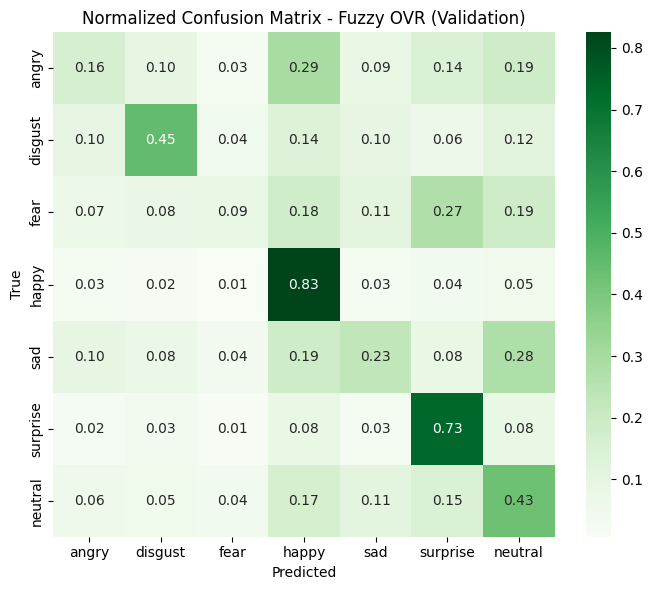

In [140]:
cm = confusion_matrix(y_val_valid, y_val_pred, normalize="true")

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=list(emotion_labels.values()),
            yticklabels=list(emotion_labels.values()))
plt.title("Normalized Confusion Matrix - Fuzzy OVR (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()


# ------------------------------------------------
# 2. Classification Report (F1, Precision, Recall)
# ------------------------------------------------
# --- Classification Report (Display Only, No Save) ---
report = classification_report(
    y_val_valid, y_val_pred,
    target_names=list(emotion_labels.values()),
    output_dict=True
)
df_report = pd.DataFrame(report).T.round(4)
df_emotions = df_report.iloc[:7]
df_summary  = df_report.iloc[7:].drop(index="accuracy", errors="ignore")

overall_acc = accuracy_score(y_val_valid, y_val_pred)

print("\n=== Per-Emotion Performance ===")
print(df_emotions)

print("\n=== Overall Summary ===")
print(df_summary)

print(f"\n=== Overall Accuracy === {overall_acc:.4f}")



In [141]:
# --- Testing on PrivateTest Set ---
scores_test = np.column_stack([fuzzy_score(m, X_test_fuzzy_clean) for m in ovr_models])
y_test_pred = np.argmax(scores_test, axis=1)


=== Test Per-Emotion Performance ===
          precision  recall  f1-score  support
angry        0.3467  0.1848    0.2411    422.0
disgust      0.0891  0.3913    0.1452     46.0
fear         0.3711  0.0771    0.1277    467.0
happy        0.6220  0.8480    0.7176    842.0
sad          0.4169  0.2568    0.3178    518.0
surprise     0.4246  0.7113    0.5318    388.0
neutral      0.4408  0.4717    0.4557    600.0

=== Test Overall Summary ===
              precision  recall  f1-score  support
macro avg        0.3873  0.4201    0.3624   3283.0
weighted avg     0.4546  0.4685    0.4315   3283.0

=== Test Overall Accuracy === 0.4685


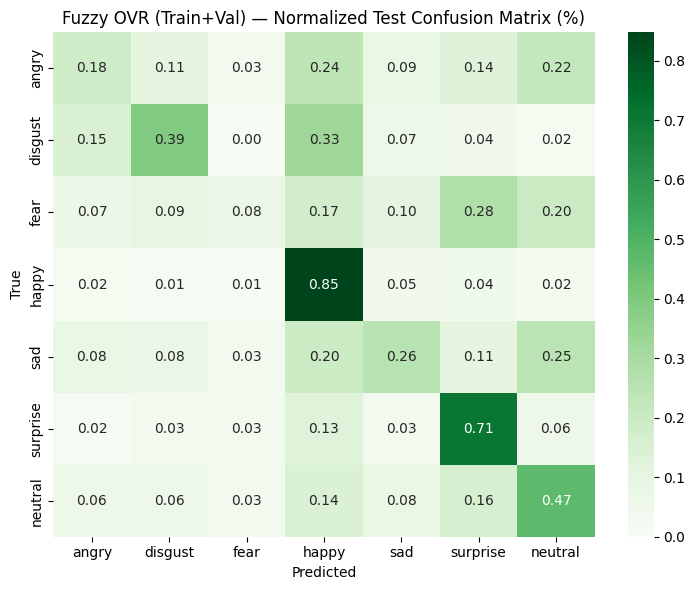

In [142]:

# Compute normalized confusion matrix for the test set
cm = confusion_matrix(
    y_test_valid,                # true labels
    y_test_pred,                 # predicted labels
    labels=list(range(7)),       # emotion label indices
    normalize="true"             # normalize by true class counts (row-wise)
)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(7.5, 6))
sns.heatmap(
    cm,
    annot=True,                  # display numeric values
    fmt=".2f",                   # format as floating-point with 2 decimals
    cmap="Greens",               # color palette
    xticklabels=[emotion_labels[i] for i in range(7)],  # predicted labels
    yticklabels=[emotion_labels[i] for i in range(7)]   # true labels
)
plt.title("Fuzzy OVR (Train+Val) — Normalized Test Confusion Matrix (%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

report_test = classification_report(
    y_test_valid,
    y_test_pred,
    target_names=list(emotion_labels.values()),
    output_dict=True
)
df_report_test = pd.DataFrame(report_test).T.round(4)

df_emotions_test = df_report_test.iloc[:7]
df_summary_test  = df_report_test.iloc[7:].drop(index="accuracy", errors="ignore")
overall_acc_test = accuracy_score(y_test_valid, y_test_pred)

print("\n=== Test Per-Emotion Performance ===")
print(df_emotions_test)

print("\n=== Test Overall Summary ===")
print(df_summary_test)

print(f"\n=== Test Overall Accuracy === {overall_acc_test:.4f}")

In [143]:
# --- Save trained fuzzy models for later demo use ---
os.makedirs("models", exist_ok=True)

for i, model in enumerate(ovr_models):
    path = f"models/fuzzy_model_class_{i}.joblib"
    joblib.dump(model, path)
    print(f"Saved fuzzy model for class {i} ({emotion_labels[i]}) → {path}")

Saved fuzzy model for class 0 (angry) → models/fuzzy_model_class_0.joblib
Saved fuzzy model for class 1 (disgust) → models/fuzzy_model_class_1.joblib
Saved fuzzy model for class 2 (fear) → models/fuzzy_model_class_2.joblib
Saved fuzzy model for class 3 (happy) → models/fuzzy_model_class_3.joblib
Saved fuzzy model for class 4 (sad) → models/fuzzy_model_class_4.joblib
Saved fuzzy model for class 5 (surprise) → models/fuzzy_model_class_5.joblib
Saved fuzzy model for class 6 (neutral) → models/fuzzy_model_class_6.joblib
